In [ ]:
%pip install earthaccess
%pip install cartopy
%pip install xarray
%pip install pandas
%pip install pathlib
%pip install h5netcdf
%pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 19.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.5.1 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Setup

Begin by importing all of the packages used in this notebook. If your kernel uses an environment defined following the guidance on the [tutorials] page, then the imports will be successful.

[tutorials]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials

In [ ]:
import cartopy.crs as ccrs
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import pathlib

In [ ]:
# Read the csv file for a month in a year.

df = pd.read_csv('/content/drive/MyDrive/MIDS-210/MODIS_DATAFRAMES/master_df_2017_03.csv')

In [ ]:
df

,Unnamed: 0,lat,lon,Rrs_412,year,month,Rrs_443,Rrs_469,Rrs_488,Rrs_531,Rrs_547,Rrs_555,Rrs_645,Rrs_667,Rrs_678
0,1330,41.395832,-82.562500,0.006412,2017,3,0.010412,0.013676,0.015204,0.021514,0.023316,0.022772,0.018008,0.016022,0.015438
1,1331,41.395832,-82.520830,0.006472,2017,3,0.010520,0.013746,0.015310,0.021602,0.023346,0.022856,0.018356,0.016380,0.015798
2,1332,41.395832,-82.479164,0.006576,2017,3,0.010706,0.013872,0.015492,0.021754,0.023398,0.023002,0.018964,0.017008,0.016426
3,1473,41.437500,-82.604164,0.005596,2017,3,0.008776,0.011578,0.012892,0.018044,0.019382,0.019018,0.012002,0.009898,0.009428
4,1474,41.437500,-82.562500,0.006176,2017,3,0.009508,0.012388,0.013678,0.019008,0.020446,0.020054,0.014018,0.011992,0.011496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,6454,42.854164,-79.062500,0.005856,2017,3,0.008984,0.012048,0.013488,0.017194,0.017858,0.017202,0.009052,0.007910,0.007546
1686,6455,42.854164,-79.020830,0.005890,2017,3,0.009016,0.012000,0.013448,0.017224,0.017908,0.017260,0.009150,0.008006,0.007626
1687,6456,42.854164,-78.979164,0.004966,2017,3,0.007942,0.010726,0.012110,0.015576,0.016172,0.015572,0.008102,0.007098,0.006764
1688,6457,42.854164,-78.937500,0.004224,2017,3,0.007330,0.010168,0.011620,0.015304,0.016004,0.015428,0.008438,0.007444,0.007118


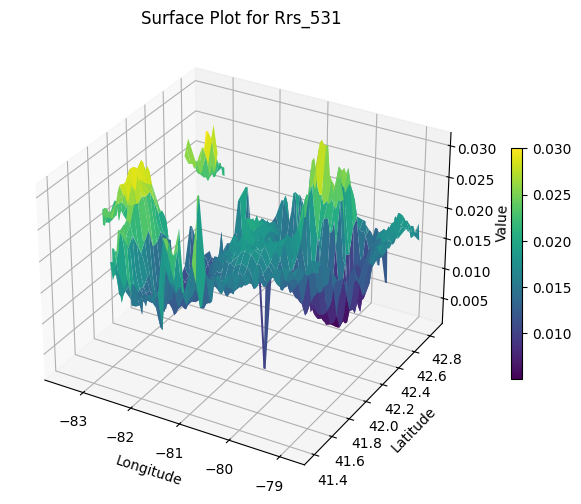

In [ ]:
# Assuming regular grid — reshape to match a lat-lon mesh
df_pivot = df.pivot_table(index='lat', columns='lon', values='Rrs_531')

# Convert to 2D grid arrays
lat = df_pivot.index.values
lon = df_pivot.columns.values
z = df_pivot.values

lon_grid, lat_grid = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(lon_grid, lat_grid, z, cmap='viridis')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Value')

fig.colorbar(surf, ax=ax, shrink=0.5)
plt.title('Surface Plot for Rrs_531')
plt.show()


In [ ]:
waves = ['Rrs_412', 'Rrs_443',
       'Rrs_469', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645',
       'Rrs_667', 'Rrs_678']

In [ ]:
for wave in waves:
    print(f' {wave}: {df[df[wave] > 0.03].shape}')


 Rrs_412: (0, 15)
 Rrs_443: (0, 15)
 Rrs_469: (0, 15)
 Rrs_488: (0, 15)
 Rrs_531: (14, 15)
 Rrs_547: (25, 15)
 Rrs_555: (7, 15)
 Rrs_645: (0, 15)
 Rrs_667: (0, 15)
 Rrs_678: (0, 15)


In [ ]:
df[df['Rrs_412'] > 0.02].shape

(0, 15)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_reflectance_map(df, wave):
  # Create plot
  fig = plt.figure(figsize=(10, 6))
  ax = plt.axes(projection=ccrs.PlateCarree())

  # Optional: zoom into a region (e.g., Lake Erie)
  ax.set_extent([-84, -78, 41, 43], crs=ccrs.PlateCarree())

  # Scatter plot with color mapped to reflectance
  sc = ax.scatter(df['lon'], df['lat'], c=df['Rrs_412'],
                  cmap='viridis', s=20, edgecolor='k', transform=ccrs.PlateCarree())

  # Add map features
  ax.add_feature(cfeature.COASTLINE)
  ax.add_feature(cfeature.BORDERS, linestyle=':')
  ax.add_feature(cfeature.LAKES, edgecolor='gray', facecolor='none')
  ax.gridlines(draw_labels=True)

  # Add colorbar
  title = f'Reflectance value for {wave}'
  plt.colorbar(sc, ax=ax, label=title)
  plt.title(f'Reflectance ({wave}) Overlay on Latitude-Longitude Map')
  plt.show()


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


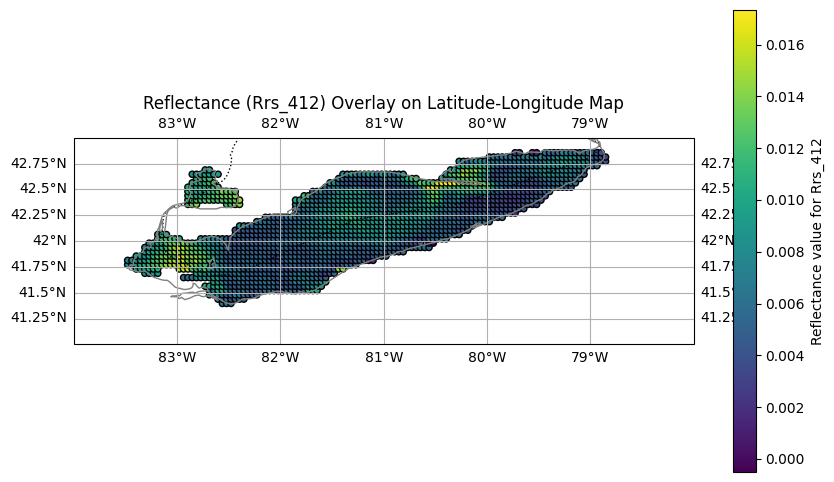

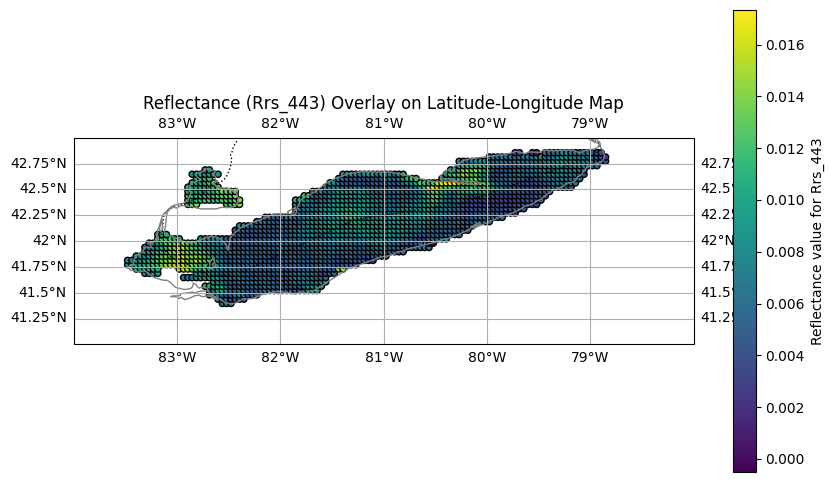

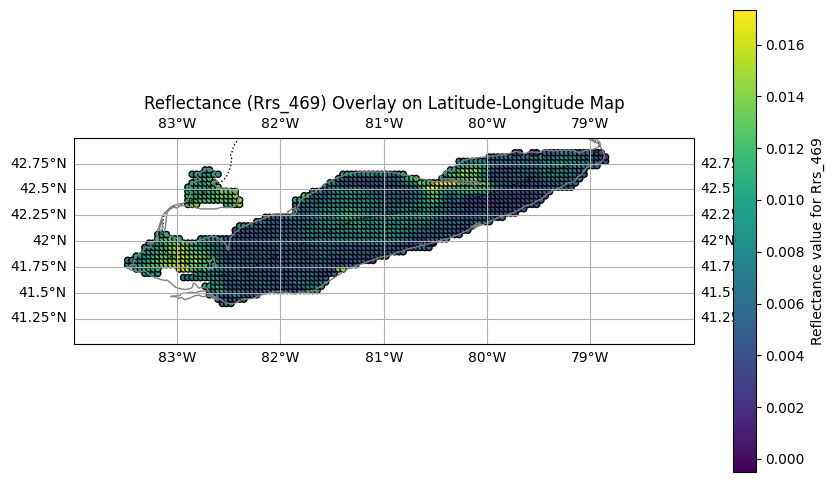

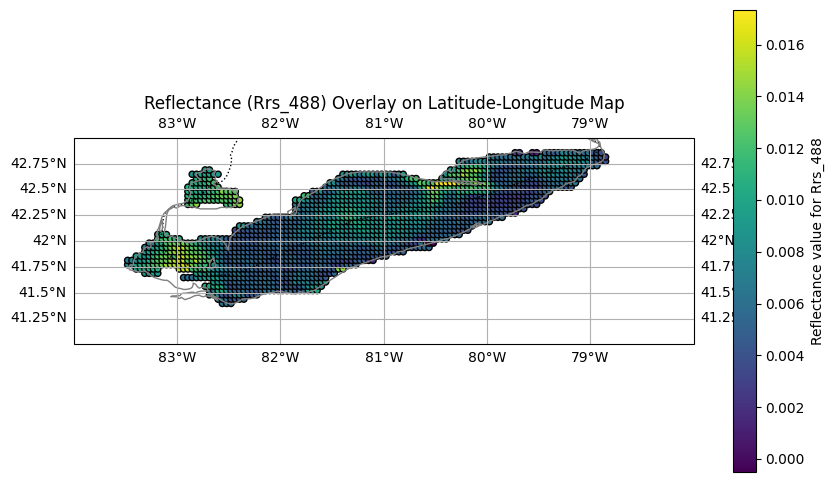

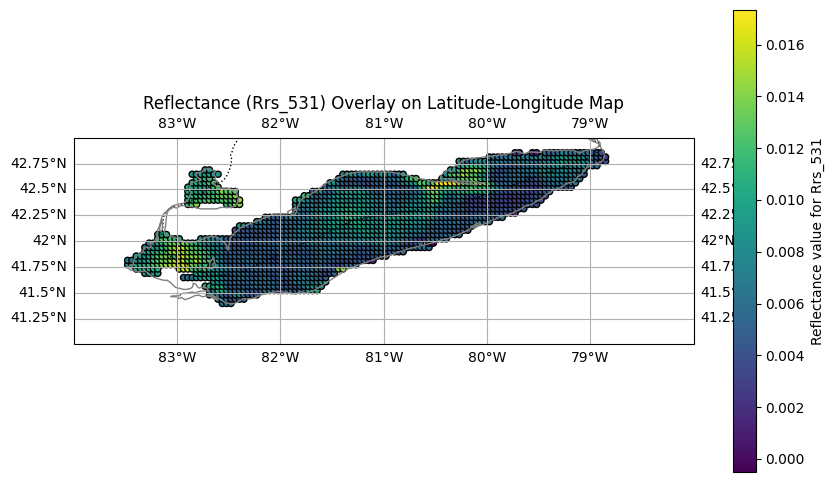

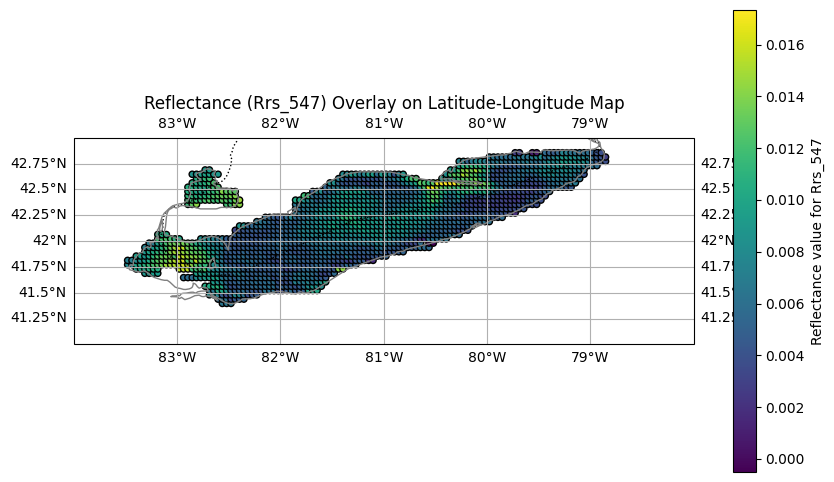

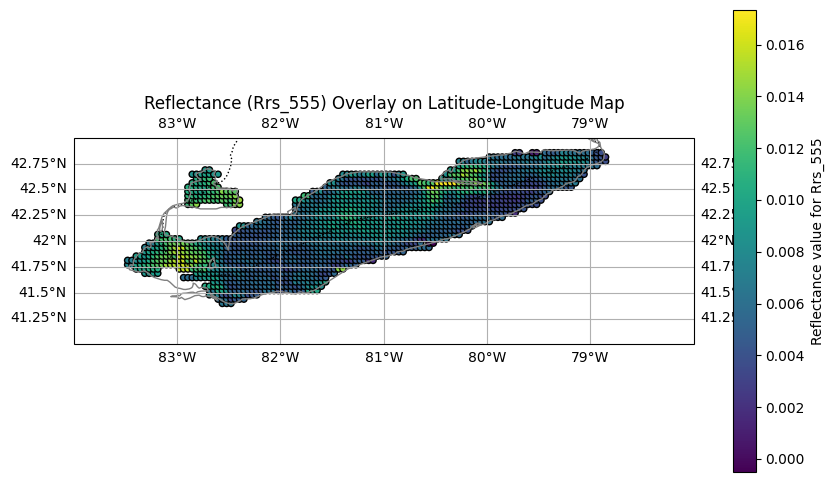

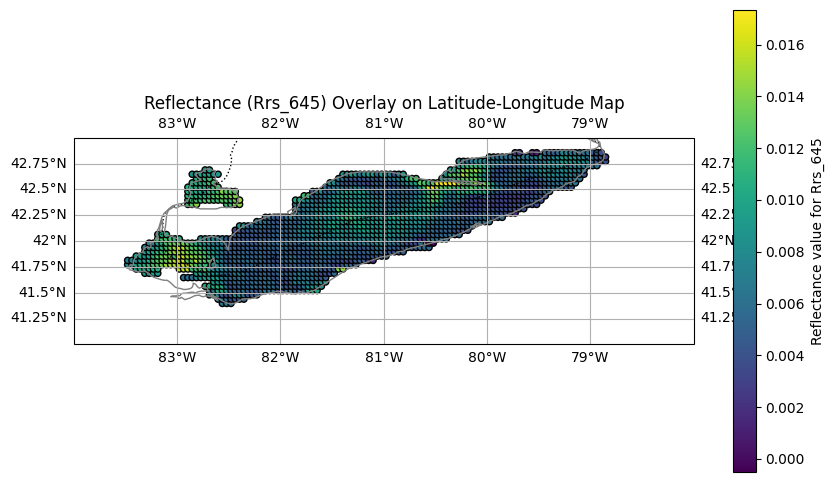

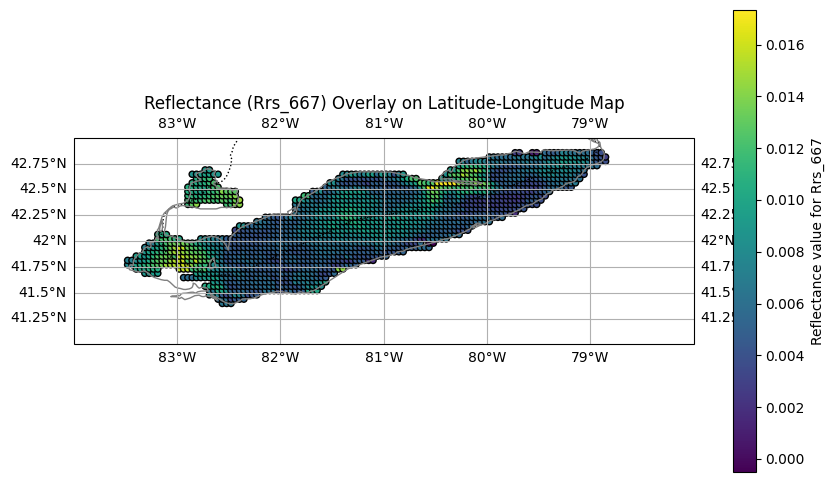

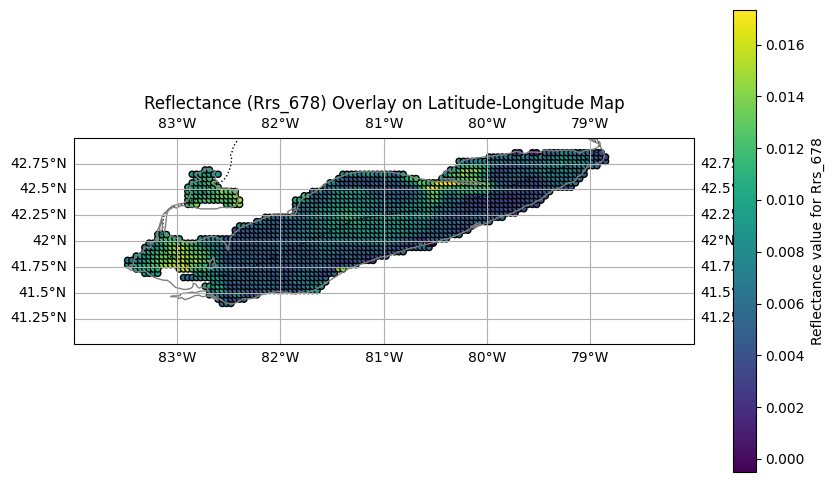

In [ ]:
for wave in waves:
  plot_reflectance_map(df, wave)


## Mean Reflectance
Lets plot the mean reflectance of a wavelength across months and years.

In [ ]:
list_temp = []
dict_temp = {}

for year in range(2014, 2025):
  for month in range(1, 13):
    file = f'/content/drive/MyDrive/MIDS-210/MODIS_DATAFRAMES/master_df_{year}_{month:02}.csv'
    if pathlib.Path(file).is_file():
      df = pd.read_csv(file)
    for wave in waves:
      dict_temp['year'] = year
      dict_temp['month'] = month
      dict_temp['wave'] = wave
      dict_temp['mean'] = df[wave].mean()
      list_temp.append(dict_temp)
      dict_temp = {}

df_means = pd.DataFrame(list_temp)

In [ ]:
df_means['tslot'] = (df_means['year'] % 2014) * 12 + df_means['month']

In [ ]:
df_means

,year,month,wave,mean,tslot
0,2014,1,Rrs_412,0.012784,1
1,2014,1,Rrs_443,0.013353,1
2,2014,1,Rrs_469,0.015015,1
3,2014,1,Rrs_488,0.015646,1
4,2014,1,Rrs_531,0.017585,1
...,...,...,...,...,...
1315,2024,12,Rrs_547,0.017137,132
1316,2024,12,Rrs_555,0.016675,132
1317,2024,12,Rrs_645,0.011714,132
1318,2024,12,Rrs_667,0.010450,132


In [ ]:
df_ts = pd.DataFrame()
for wave in waves:
  wave_mean = df_means[df_means['wave'] == wave]['mean'].reset_index(drop=True)
  wave_ts = df_means[df_means['wave'] == wave]['tslot'].reset_index(drop=True)
  df_ts[wave] = wave_mean
  df_ts['tslot'] = wave_ts
  print(wave_mean)


0      0.012784
1      0.009040
2      0.005277
3      0.003733
4      0.002936
         ...   
127    0.001435
128    0.000973
129    0.002535
130    0.004818
131    0.011040
Name: mean, Length: 132, dtype: float64
0      0.013353
1      0.008528
2      0.005558
3      0.004939
4      0.003781
         ...   
127    0.001998
128    0.001788
129    0.003125
130    0.005136
131    0.011644
Name: mean, Length: 132, dtype: float64
0      0.015015
1      0.009191
2      0.006404
3      0.006284
4      0.004666
         ...   
127    0.002753
128    0.002674
129    0.004115
130    0.006041
131    0.012597
Name: mean, Length: 132, dtype: float64
0      0.015646
1      0.009316
2      0.006726
3      0.006950
4      0.005116
         ...   
127    0.003358
128    0.003354
129    0.004934
130    0.007112
131    0.014012
Name: mean, Length: 132, dtype: float64
0      0.017585
1      0.010508
2      0.007812
3      0.008640
4      0.006443
         ...   
127    0.005323
128    0.005278
129    0

In [ ]:
df_ts

,Rrs_412,tslot,Rrs_443,Rrs_469,Rrs_488,Rrs_531,Rrs_547,Rrs_555,Rrs_645,Rrs_667,Rrs_678
0,0.012784,1,0.013353,0.015015,0.015646,0.017585,0.017570,0.016754,0.008262,0.007310,0.007011
1,0.009040,2,0.008528,0.009191,0.009316,0.010508,0.010623,0.010214,0.003702,0.003095,0.003008
2,0.005277,3,0.005558,0.006404,0.006726,0.007812,0.007846,0.007482,0.002229,0.001867,0.001814
3,0.003733,4,0.004939,0.006284,0.006950,0.008640,0.008773,0.008402,0.003115,0.002624,0.002499
4,0.002936,5,0.003781,0.004666,0.005116,0.006443,0.006487,0.006143,0.001576,0.001233,0.001187
...,...,...,...,...,...,...,...,...,...,...,...
127,0.001435,128,0.001998,0.002753,0.003358,0.005323,0.005480,0.005160,0.001480,0.001135,0.001090
128,0.000973,129,0.001788,0.002674,0.003354,0.005278,0.005459,0.005221,0.001800,0.001442,0.001388
129,0.002535,130,0.003125,0.004115,0.004934,0.006984,0.007123,0.006844,0.002925,0.002412,0.002371
130,0.004818,131,0.005136,0.006041,0.007112,0.009111,0.009217,0.008913,0.004209,0.003560,0.003490


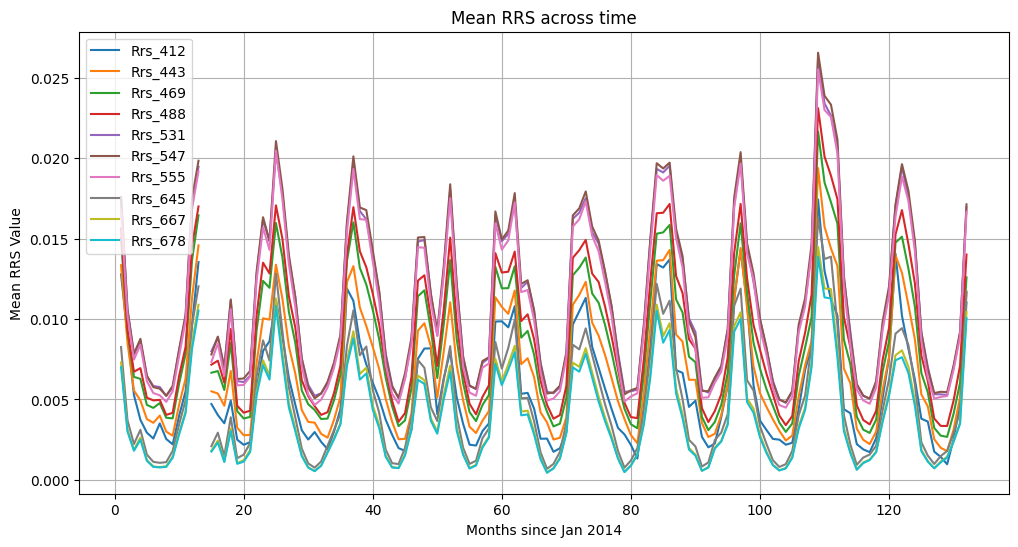

In [ ]:
# prompt: generate multi-line chart with tslot as x-axis and all other columns in y

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

for col in df_ts.columns:
  if col != 'tslot':
    plt.plot(df_ts['tslot'], df_ts[col], label=col)

plt.xlabel('Months since Jan 2014')
plt.ylabel('Mean RRS Value')
plt.title('Mean RRS across time')
plt.legend()
plt.grid(True)
plt.show()